### Portfolio assignment <br>

#### Clustering space radio waves to detect pulsars (neutron stars). <br>

The work is done by Ilia Semenok. <br>

I'm a data scientist working for NASA. My team has been collecting radio waves from space using telescopes for the last several months. <br>
My goal is to group these signals into two groups: "Pulsar" or "Not a Pulsar". <br>
By doing so, I will simplify further exploration of pulsars. Having an algorithm that separates all the incoming radio waves into <br>
an unwanted "noise" and valuable potential pulsars will save a lot of time. <br>
After I label the data it can then be used for classification of new incoming radio waves. <br>
Once I identify potential pulsars my team will deeper investigate these stars. A probe might be sent to the nearest one in the future. <br>
I could also try to find an unkown group of objects or something like that.

Pulsars are a  type of neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as <br> extreme states of matter, strong magnetic fields etc. <br>
As pulsars rotate, their emission beam sweeps across the sky and produces a detectable pattern of radio emission. As pulsars rotate rapidly,<br> this pattern repeats periodically. Thus pulsar search involves looking for periodic radio signals with large radio telescopes. <br>

Each pulsar produces a slightly different emission pattern, which varies slightly with each rotation. Thus a potential signal detection known<br>
as a 'candidate', is averaged over many rotations of the pulsar, as determined by the length of an observation. In the absence of additional<br> info, each candidate could potentially describe a real pulsar. However in practice almost all detections are caused by radio frequency <br>
interference (RFI) and noise, making legitimate signals hard to find. <br>

Now let's have a look at the dataset. <br>
Available here: <br>
https://archive.ics.uci.edu/dataset/372/htru2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster import hierarchy
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [2]:
df_or = pd.read_csv(r"HTRU_2.csv", names=['mean', 'sd', 'excess kurtosis', 'skewness', 
                                                                      'mean2', 'sd2', 'excess kurtosis2', 'skewness2', 'pulsar'])
df_or   # original dataframe.

mean         sd  excess kurtosis  skewness       mean2  \
0      140.562500  55.683782        -0.234571 -0.699648    3.199833   
1      102.507812  58.882430         0.465318 -0.515088    1.677258   
2      103.015625  39.341649         0.323328  1.051164    3.121237   
3      136.750000  57.178449        -0.068415 -0.636238    3.642977   
4       88.726562  40.672225         0.600866  1.123492    1.178930   
...           ...        ...              ...       ...         ...   
17893  136.429688  59.847421        -0.187846 -0.738123    1.296823   
17894  122.554688  49.485605         0.127978  0.323061   16.409699   
17895  119.335938  59.935939         0.159363 -0.743025   21.430602   
17896  114.507812  53.902400         0.201161 -0.024789    1.946488   
17897   57.062500  85.797340         1.406391  0.089520  188.306020   

             sd2  excess kurtosis2   skewness2  pulsar  
0      19.110426          7.975532   74.242225       0  
1      14.860146         10.576487  127.393580       0  
2      21.744669          7.735822   63.171909       0  
3      20.959280          6.896499   53.593661       0  
4      11.468720         14.269573  252.567306       0  
...          ...               ...         ...     ...  
17893  12.166062         15.450260  285.931022       0  
17894  44.626893          2.945244    8.297092       0  
17895  58.872000          2.499517    4.595173       0  
17896  13.381731         10.007967  134.238910       0  
17897  64.712562         -1.597527    1.429475       0  

[17898 rows x 9 columns]

As can be seen there are 8 features, a target variable "pulsar" and almost 18 hundred entries. <br>

Each candidate (row) is described by 8 continuous variables. The first four are simple statistics obtained from the integrated pulse profile<br> (folded profile). This is an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged <br>
in both time and frequency. The remaining four variables are similarly obtained from the DM-SNR (Dispersion Measure/Signal-to-Noise Ratio) curve. <br>

The original data was like that:

	1. Mean of the integrated profile.
	2. Standard deviation of the integrated profile.
	3. Excess kurtosis of the integrated profile.
	4. Skewness of the integrated profile.
	5. Mean of the DM-SNR curve.
	6. Standard deviation of the DM-SNR curve.
	7. Excess kurtosis of the DM-SNR curve.
	8. Skewness of the DM-SNR curve.

For simplicity I renamed first 4 features of integrated profile into just 'mean', 'sd', 'excess kurtosis' and 'skewness'. <br>
I added a notation '2' for the last 4 features (columns) related to DM-SNR curve. <br>

The last column represents the "answers" for our future clusters. Let's drop it.

In [3]:
df = df_or.loc[:,'mean': 'skewness2']
df

mean         sd  excess kurtosis  skewness       mean2  \
0      140.562500  55.683782        -0.234571 -0.699648    3.199833   
1      102.507812  58.882430         0.465318 -0.515088    1.677258   
2      103.015625  39.341649         0.323328  1.051164    3.121237   
3      136.750000  57.178449        -0.068415 -0.636238    3.642977   
4       88.726562  40.672225         0.600866  1.123492    1.178930   
...           ...        ...              ...       ...         ...   
17893  136.429688  59.847421        -0.187846 -0.738123    1.296823   
17894  122.554688  49.485605         0.127978  0.323061   16.409699   
17895  119.335938  59.935939         0.159363 -0.743025   21.430602   
17896  114.507812  53.902400         0.201161 -0.024789    1.946488   
17897   57.062500  85.797340         1.406391  0.089520  188.306020   

             sd2  excess kurtosis2   skewness2  
0      19.110426          7.975532   74.242225  
1      14.860146         10.576487  127.393580  
2      21.744669          7.735822   63.171909  
3      20.959280          6.896499   53.593661  
4      11.468720         14.269573  252.567306  
...          ...               ...         ...  
17893  12.166062         15.450260  285.931022  
17894  44.626893          2.945244    8.297092  
17895  58.872000          2.499517    4.595173  
17896  13.381731         10.007967  134.238910  
17897  64.712562         -1.597527    1.429475  

[17898 rows x 8 columns]

Now I will quickly explore my dataset.

In [4]:
df.isnull().sum()   # Checking for null values.

mean                0
sd                  0
excess kurtosis     0
skewness            0
mean2               0
sd2                 0
excess kurtosis2    0
skewness2           0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean              17898 non-null  float64
 1   sd                17898 non-null  float64
 2   excess kurtosis   17898 non-null  float64
 3   skewness          17898 non-null  float64
 4   mean2             17898 non-null  float64
 5   sd2               17898 non-null  float64
 6   excess kurtosis2  17898 non-null  float64
 7   skewness2         17898 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [6]:
df.describe()

mean            sd  excess kurtosis      skewness  \
count  17898.000000  17898.000000     17898.000000  17898.000000   
mean     111.079968     46.549532         0.477857      1.770279   
std       25.652935      6.843189         1.064040      6.167913   
min        5.812500     24.772042        -1.876011     -1.791886   
25%      100.929688     42.376018         0.027098     -0.188572   
50%      115.078125     46.947479         0.223240      0.198710   
75%      127.085938     51.023202         0.473325      0.927783   
max      192.617188     98.778911         8.069522     68.101622   

              mean2           sd2  excess kurtosis2     skewness2  
count  17898.000000  17898.000000      17898.000000  17898.000000  
mean      12.614400     26.326515          8.303556    104.857709  
std       29.472897     19.470572          4.506092    106.514540  
min        0.213211      7.370432         -3.139270     -1.976976  
25%        1.923077     14.437332          5.781506     34.960504  
50%        2.801839     18.461316          8.433515     83.064556  
75%        5.464256     28.428104         10.702959    139.309330  
max      223.392141    110.642211         34.539844   1191.000837

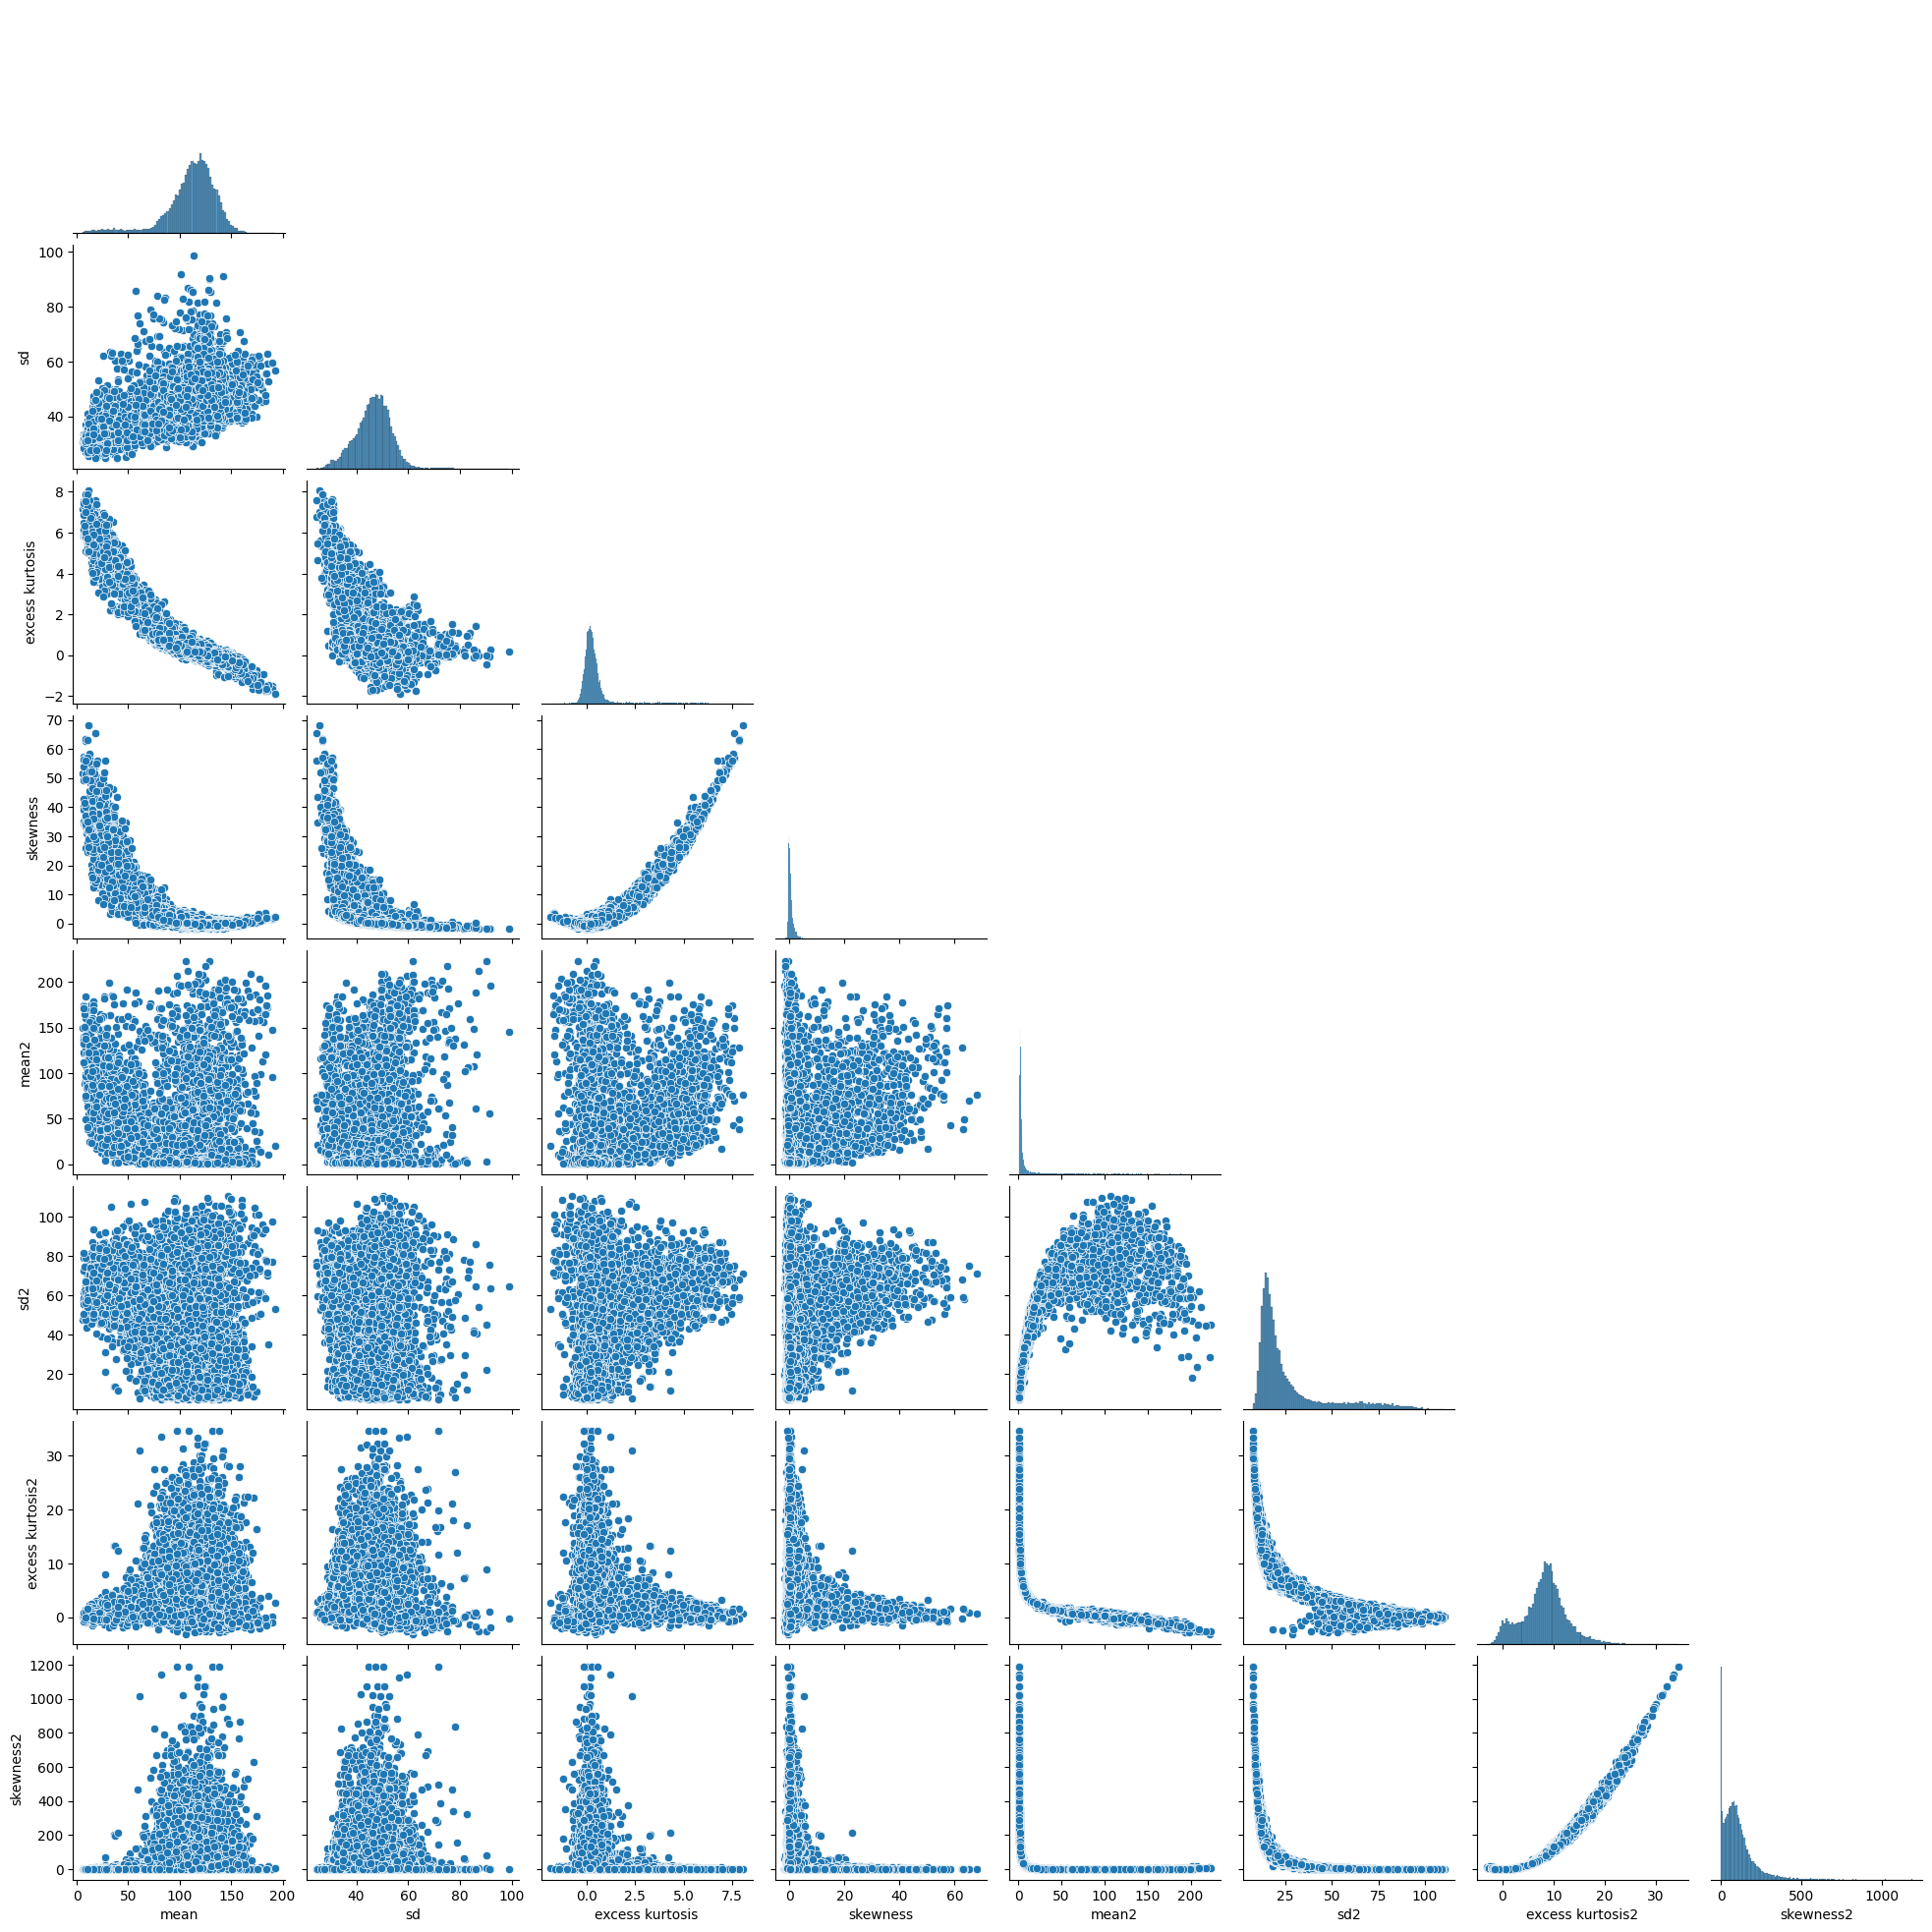

In [7]:
sns.pairplot(df, corner=True)
plt.show()

Just to have bigger graphs for features' distribution I will plot them again:

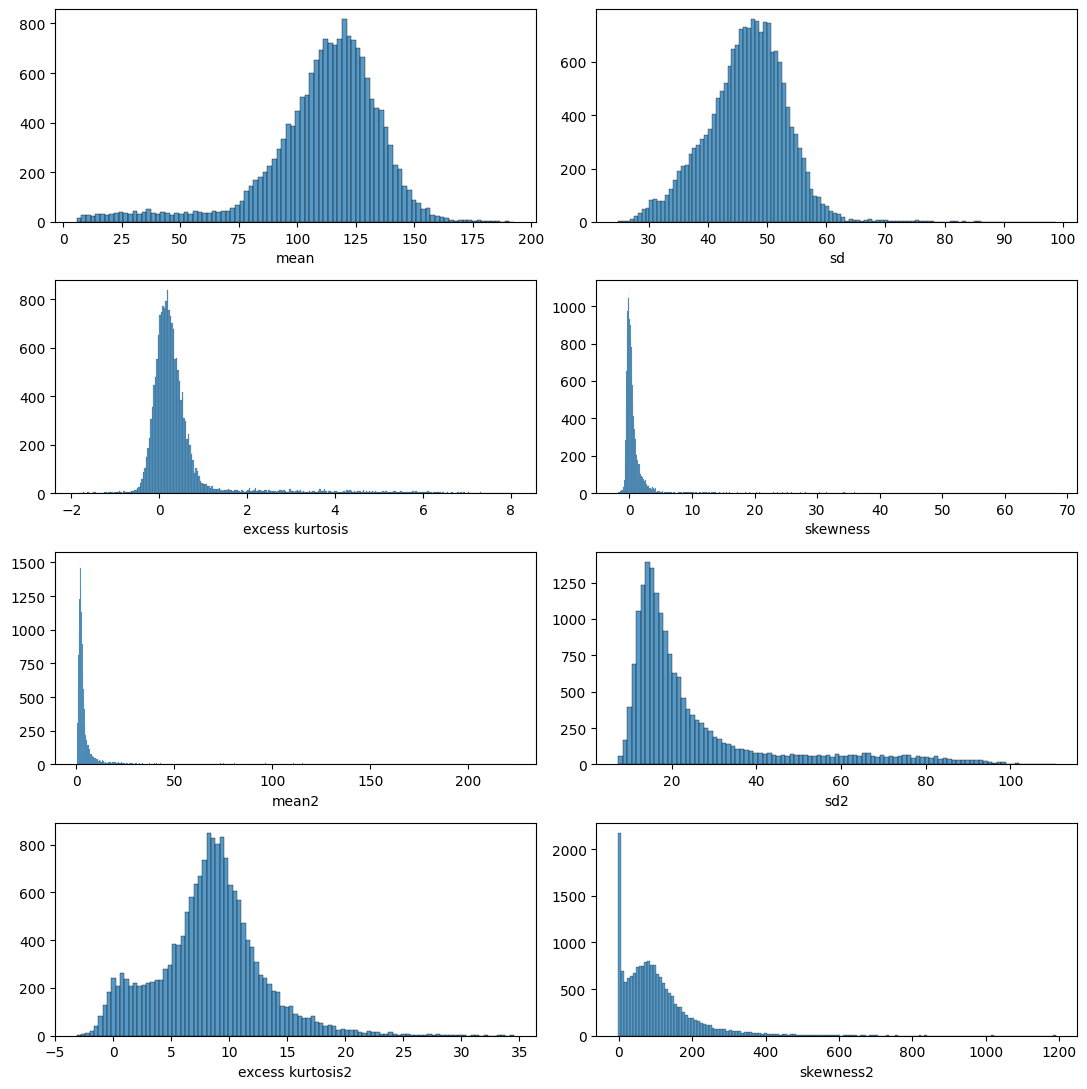

In [8]:
figure, axes = plt.subplots(4, 2, figsize=(11,11))
for i, ax in enumerate(axes.flatten()):
    column = df.columns[i]
    sns.histplot(df[column], ax=ax)
    ax.set(ylabel='')

plt.tight_layout()


Most of the graphs have more or less normal distribution. However, outliers are significantly present in <br>
'excess kurtosis', 'skewness', 'mean2' and 'skewness2' columns. <br>
I will leave the data as it is. <br>

Scaling the data using StandardScaler. <br>

I tried using MinMaxScaler as well and the results were very similar I have to say.

In [9]:
scaler = StandardScaler()
df_sc = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_sc   # Scaled dataframe.

mean        sd  excess kurtosis  skewness     mean2       sd2  \
0      1.149317  1.334832        -0.669570 -0.400459 -0.319440 -0.370625   
1     -0.334168  1.802265        -0.011785 -0.370535 -0.371102 -0.588924   
2     -0.314372 -1.053322        -0.145233 -0.116593 -0.322107 -0.235328   
3      1.000694  1.553254        -0.513409 -0.390178 -0.304404 -0.275666   
4     -0.871402 -0.858879         0.115609 -0.104866 -0.388010 -0.763111   
...         ...       ...              ...       ...       ...       ...   
17893  0.988208  1.943284        -0.625655 -0.406697 -0.384010 -0.727295   
17894  0.447319  0.429062        -0.328831 -0.234643  0.128776  0.939926   
17895  0.321842  1.956220        -0.299334 -0.407492  0.299137  1.671568   
17896  0.133628  1.074510        -0.260050 -0.291041 -0.361967 -0.664857   
17897 -2.105762  5.735470         0.872674 -0.272508  5.961291  1.971546   

       excess kurtosis2  skewness2  
0             -0.072798  -0.287438  
1              0.504427   0.211581  
2             -0.125996  -0.391373  
3             -0.312265  -0.481300  
4              1.324026   1.386794  
...                 ...        ...  
17893          1.586054   1.700034  
17894         -1.189159  -0.906574  
17895         -1.288079  -0.941330  
17896          0.378257   0.275850  
17897         -2.197327  -0.971052  

[17898 rows x 8 columns]

In [10]:
df_sc.describe().round()

mean       sd  excess kurtosis  skewness    mean2      sd2  \
count  17898.0  17898.0          17898.0   17898.0  17898.0  17898.0   
mean      -0.0      0.0              0.0       0.0      0.0      0.0   
std        1.0      1.0              1.0       1.0      1.0      1.0   
min       -4.0     -3.0             -2.0      -1.0     -0.0     -1.0   
25%       -0.0     -1.0             -0.0      -0.0     -0.0     -1.0   
50%        0.0      0.0             -0.0      -0.0     -0.0     -0.0   
75%        1.0      1.0             -0.0      -0.0     -0.0      0.0   
max        3.0      8.0              7.0      11.0      7.0      4.0   

       excess kurtosis2  skewness2  
count           17898.0    17898.0  
mean                0.0        0.0  
std                 1.0        1.0  
min                -3.0       -1.0  
25%                -1.0       -1.0  
50%                 0.0       -0.0  
75%                 1.0        0.0  
max                 6.0       10.0

Now the dataframe has a mean of approximately 0 and standard deviation of 1. <br>

#### Clustering

K-Means

At first, I'll try to use "Elbow" method to determine the number of clusters.

In [12]:
sse = []   # sse: sum of squared errors.
k_rng = range(2,11)
for k in k_rng:
    km = KMeans(n_clusters=k, random_state=40, n_init=30)
    km.fit(df_sc)
    sse.append(km.inertia_) 
sse

[92214.3682143729,
 68071.97894325387,
 53121.61413724731,
 44219.055532033955,
 39133.65910621208,
 34352.09374472875,
 31190.122512540525,
 29189.87432933551,
 27478.61496965761]

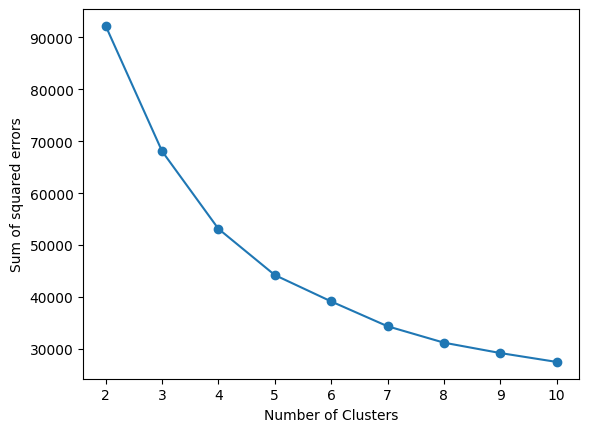

In [13]:
plt.plot(k_rng, sse, marker='o')

plt.xlabel('Number of Clusters')   
plt.ylabel('Sum of squared errors')
plt.show()

It's difficult to determine the correct number of clusters using Elbow method. Let's try the silhouette score instead.

In [14]:
silhouettes = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=40, n_init=30)
    clusters = kmeans.fit_predict(df_sc)
    silhouettes.append(silhouette_score(df_sc, clusters))
silhouettes 

[0.6011060556631193,
 0.517417802460797,
 0.354843553240933,
 0.3033160051314497,
 0.2681342894120065,
 0.27301819535125615,
 0.27836507542681055,
 0.2465381921367351,
 0.2326180775392699]

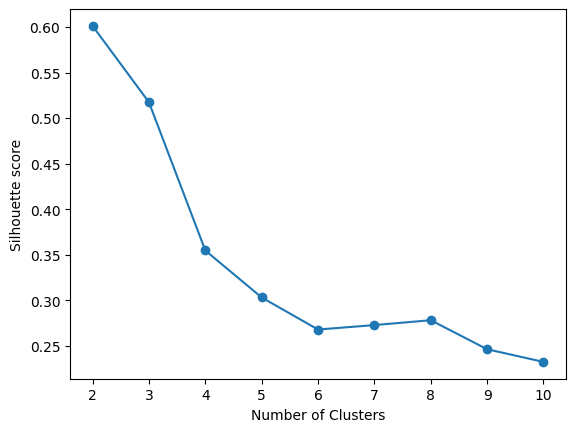

In [15]:
plt.plot(range(2,11), silhouettes, marker='o')
plt.xlabel('Number of Clusters')   
plt.ylabel('Silhouette score')
plt.show()

It seems that either 2 or 3 clusters can be formed. 4 groups and more have a very low Silhouette score. <br>
I will choose 2 for k, because the Silhouette score is higher. 

In [16]:
km = KMeans(n_clusters=2, random_state=40, algorithm='elkan', n_init=50, tol=0.0001)
elkan_predicted = km.fit_predict(df_sc)
elkan_predicted

array([0, 0, 0, ..., 0, 0, 1])

In [17]:
km = KMeans(n_clusters=2, random_state=40, algorithm='lloyd', n_init=50, tol=0.0001)
k_predicted = km.fit_predict(df_sc)
k_predicted

array([0, 0, 0, ..., 0, 0, 1])

In [18]:
(elkan_predicted==k_predicted).all()

True

By running two different algorithms 'elkan' and 'lloyd' the resulting clusters turn out to be the same. <br>
I will change relative tolerance "tol" to 0.1 and compare it again with my "lloyd" algorithm.

In [19]:
km = KMeans(n_clusters=2, random_state=40, algorithm='elkan', n_init=50, tol=0.1)
elkan2_predicted = km.fit_predict(df_sc)

In [20]:
print(sum(elkan2_predicted==k_predicted))
print(df_sc.shape)

17894
(17898, 8)


In [21]:
print(pd.Series(elkan2_predicted).value_counts())
print(pd.Series(k_predicted).value_counts())

0    15837
1     2061
Name: count, dtype: int64
0    15841
1     2057
Name: count, dtype: int64


Only 4 points are different within 2 clusters. Not much of a difference. So, it doesn't really matter which one to choose. <br>
I will choose k_predicted result, that has algorithm='lloyd', n_init=50, tol=0.0001 and default init which is k-means++

#### DBSCAN

The code was taken from: <br>
https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/ <br>
https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd

In [22]:
neighbors = NearestNeighbors(n_neighbors=16)
neighbors_fit = neighbors.fit(df_sc)
distances, indices = neighbors_fit.kneighbors(df_sc)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

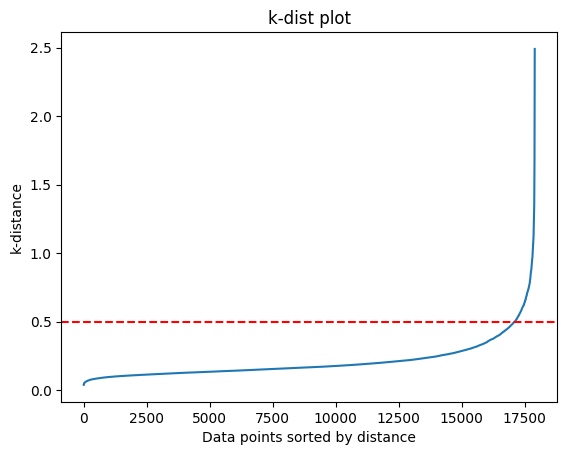

In [23]:
plt.plot(distances)
plt.title("k-dist plot")
plt.xlabel("Data points sorted by distance")
plt.ylabel("k-distance")
plt.axhline(y=0.5, color='r', linestyle='--')
plt.show()

For the "eps" I plotted a graph to see the most fitting value, which is around 0.5. But I went with 0.45. <br>
For the "min_samples" I chose 16, following a rule of thumb. "min_samples" = 2*n, where n is a number of dimensions.

In [24]:
clusters = DBSCAN(eps=0.45, min_samples=16).fit(df_sc)
d_predicted = clusters.labels_
d_predicted

array([ 0,  0,  0, ...,  0,  0, -1], dtype=int64)

In [25]:
pd.Series(d_predicted).value_counts()

 0    14772
-1     3109
 1       17
Name: count, dtype: int64

It shows that 3109 values are outliers. However, I will treat them as one cluster together with 17 values from group 1.

In [26]:
d_predicted[d_predicted != 0] = 1

In [27]:
pd.Series(d_predicted).value_counts()

0    14772
1     3126
Name: count, dtype: int64

I wil not use DBSCAN as my second method, because the clusters it produced look like outliers. <br>
I just wanted to see what this density-based method produces in comparison to others.

#### Hierarchical Clustering (HAC)

The code was taken from: <br>
https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/

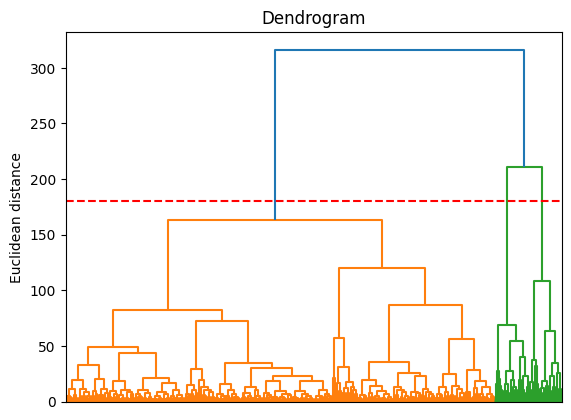

In [28]:
hierarchy.dendrogram(hierarchy.linkage(df_sc, method='ward'))

plt.title('Dendrogram')
plt.ylabel('Euclidean distance')
plt.xticks([])
plt.axhline(y=180, color='r', linestyle='--')
plt.show()

From the dendrogram we can clearly see two big groups denoted in orange and green colours respectively. <br>
However, we can also create 3 clusters as the red dotted line shows. <br>
It's actually a difficult choice to make, but I will stick with 2 clusters here. <br>

In [29]:
cluster = AgglomerativeClustering(n_clusters=2, metric='manhattan', linkage='average')
cluster.fit(df_sc)
manhattan_predicted = cluster.labels_
manhattan_predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [30]:
cluster = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
cluster.fit(df_sc)
h_predicted = cluster.labels_
h_predicted

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [31]:
print(pd.Series(manhattan_predicted).value_counts())   # manhattan
print(pd.Series(h_predicted).value_counts())           # euclidean

0    16667
1     1231
Name: count, dtype: int64
1    15531
0     2367
Name: count, dtype: int64


In [32]:
h_predicted = 1 - h_predicted   # To switch zeros with ones.
pd.Series(h_predicted).value_counts()

0    15531
1     2367
Name: count, dtype: int64

In [33]:
(manhattan_predicted==h_predicted).sum()

16744

In [34]:
df_sc.shape[0] - (manhattan_predicted==h_predicted).sum()   # 1154 points are different.

1154

Again, it's quite difficult to choose parameters. But I will go with metric "euclidean" and linkage "ward", which is h_predicted.

#### Comparing k-Means and HAC methods. <br>

In [35]:
print(k_predicted)   # from k-Means.
print(h_predicted)   # from Agglomerative Hierarchical. 

[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 1]


Creating a copy of an original unscaled dataframe to compare and visualize current clusters.

In [36]:
df_compare = df.copy(deep=True)
df_compare.head()

mean         sd  excess kurtosis  skewness     mean2        sd2  \
0  140.562500  55.683782        -0.234571 -0.699648  3.199833  19.110426   
1  102.507812  58.882430         0.465318 -0.515088  1.677258  14.860146   
2  103.015625  39.341649         0.323328  1.051164  3.121237  21.744669   
3  136.750000  57.178449        -0.068415 -0.636238  3.642977  20.959280   
4   88.726562  40.672225         0.600866  1.123492  1.178930  11.468720   

   excess kurtosis2   skewness2  
0          7.975532   74.242225  
1         10.576487  127.393580  
2          7.735822   63.171909  
3          6.896499   53.593661  
4         14.269573  252.567306

In [37]:
df_compare['k-means'] = k_predicted          # adding a cluster column of k-means.
df_compare['HAC'] = h_predicted     # adding a cluster column of hierarchical.
df_compare

mean         sd  excess kurtosis  skewness       mean2  \
0      140.562500  55.683782        -0.234571 -0.699648    3.199833   
1      102.507812  58.882430         0.465318 -0.515088    1.677258   
2      103.015625  39.341649         0.323328  1.051164    3.121237   
3      136.750000  57.178449        -0.068415 -0.636238    3.642977   
4       88.726562  40.672225         0.600866  1.123492    1.178930   
...           ...        ...              ...       ...         ...   
17893  136.429688  59.847421        -0.187846 -0.738123    1.296823   
17894  122.554688  49.485605         0.127978  0.323061   16.409699   
17895  119.335938  59.935939         0.159363 -0.743025   21.430602   
17896  114.507812  53.902400         0.201161 -0.024789    1.946488   
17897   57.062500  85.797340         1.406391  0.089520  188.306020   

             sd2  excess kurtosis2   skewness2  k-means  HAC  
0      19.110426          7.975532   74.242225        0    0  
1      14.860146         10.576487  127.393580        0    0  
2      21.744669          7.735822   63.171909        0    0  
3      20.959280          6.896499   53.593661        0    0  
4      11.468720         14.269573  252.567306        0    0  
...          ...               ...         ...      ...  ...  
17893  12.166062         15.450260  285.931022        0    0  
17894  44.626893          2.945244    8.297092        0    0  
17895  58.872000          2.499517    4.595173        0    0  
17896  13.381731         10.007967  134.238910        0    0  
17897  64.712562         -1.597527    1.429475        1    1  

[17898 rows x 10 columns]

In [38]:
display(df_compare['k-means'].value_counts().reset_index())
display(df_compare['HAC'].value_counts().reset_index())

k-means  count
0        0  15841
1        1   2057

HAC  count
0    0  15531
1    1   2367

Or I could use a Confusion Matrix to do the same visualization.

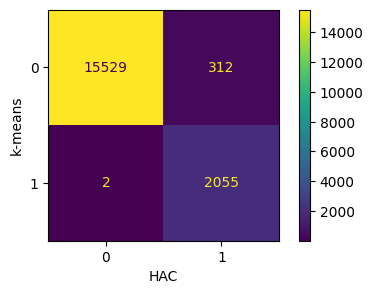

In [39]:
fig, ax = plt.subplots(figsize=(5, 3))
ConfusionMatrixDisplay.from_predictions(k_predicted, h_predicted, ax=ax)
plt.xlabel('HAC')
plt.ylabel('k-means')
plt.show()

In [40]:
(k_predicted==h_predicted).sum()   # A number of matching points between two methods.

17584

In [41]:
(k_predicted==h_predicted).sum()/df_compare.shape[0]   # 98.2 % of two methods' records are the same.

0.9824561403508771

In [42]:
df_compare[df_compare['k-means']==df_compare['HAC']]['HAC'].value_counts()
# Again a number of matching points between two methods with respect to each cluster (cluster 0 and 1).

HAC
0    15529
1     2055
Name: count, dtype: int64

In [43]:
display(df_compare.groupby('k-means')[['mean', 'sd']].agg(['mean', 'min', 'max', 'std']).reset_index())
display(df_compare.groupby('HAC')[['mean', 'sd']].agg(['mean', 'min', 'max', 'std']).reset_index())

k-means        mean                                           sd             \
                 mean        min         max        std       mean        min   
0       0  115.870351  36.039062  192.617188  17.224384  47.066559  28.698714   
1       1   74.189133   5.812500  189.734375  43.637924  42.567889  24.772042   

                         
         max        std  
0  91.206475   5.972295  
1  98.778911  10.719991

HAC        mean                                          sd             \
             mean       min         max        std       mean        min   
0   0  115.945879  56.53125  192.617188  16.824520  47.053232  28.698714   
1   1   79.152438   5.81250  190.421875  44.097851  43.244515  24.772042   

                         
         max        std  
0  90.250557   5.889110  
1  98.778911  10.676642

It might be confusing at first, since my columns are named "mean" and "sd". But I'm looking at 4 functions: <br>
'mean', 'min', 'max', 'std' which are located under "mean" and "sd" columns. <br>

The two groups formed from k-Means and Hierarchical clustering show strong similarities.

In [44]:
display(df_compare.groupby('k-means')[['skewness', 'excess kurtosis']].agg(['mean', 'min', 'max', 'std']).reset_index())
display(df_compare.groupby('HAC')[['skewness', 'excess kurtosis']].agg(['mean', 'min', 'max', 'std']).reset_index())

k-means   skewness                                 excess kurtosis  \
                mean       min        max        std            mean   
0       0   0.417494 -1.791886  11.110487   1.008022        0.228092   
1       1  12.188108 -1.781888  68.101622  14.164904        2.401305   

                                 
        min       max       std  
0 -1.876011  3.312638  0.327677  
1 -1.738021  8.069522  2.201373

HAC   skewness                                 excess kurtosis            \
            mean       min        max        std            mean       min   
0   0   0.391697 -1.791886   8.367704   0.918366        0.222222 -1.876011   
1   1  10.815805 -1.781888  68.101622  13.707676        2.155201 -1.738021   

                       
        max       std  
0  2.341728  0.301022  
1  8.069522  2.173861

The same statistical function but with respect to "skewness" and "excess kurtosis". <br>

From these 4 columns/features it is seen that cluster 1 has a much higher standard deviation than cluster 0. <br>
Which tells us, that the data is more sparse/spread out in cluster 1. <br>

Below is a visualization of a "mean" column with respect to "sd" column of both k-Means and Hierarchical methods.

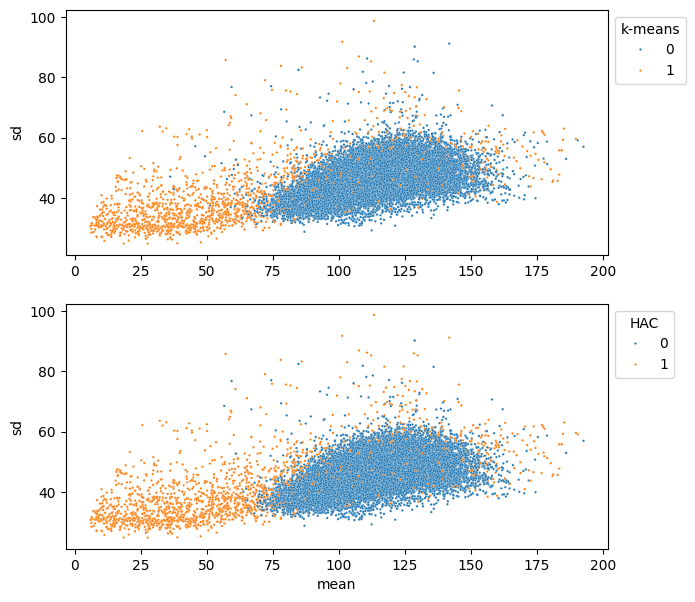

In [45]:
fig, axes = plt.subplots(2,1, figsize=(7,7))
ax1 = sns.scatterplot(data=df_compare, x='mean', y='sd', hue='k-means', s=3, ax=axes[0])
ax2 = sns.scatterplot(data=df_compare, x='mean', y='sd', hue='HAC', s=3, ax=axes[1])

sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))
ax1.set_xlabel(None)
plt.show()

Two methods, namely "k-means" and "HAC" output extremely similar groups. <br>
I will go with the hierarchical agglomerative method.

#### Implementing Principal Component Analysis (PCA)

PCA reduces the number of variables (features) in a data set while still preserving the most important information. <br>
It is a dimensionality reduction technique that helps visualizing the data.

In [46]:
df.corr().round(2)   # Looking at the correlation of the original columns.

mean    sd  excess kurtosis  skewness  mean2   sd2  \
mean              1.00  0.55            -0.87     -0.74  -0.30 -0.31   
sd                0.55  1.00            -0.52     -0.54   0.01 -0.05   
excess kurtosis  -0.87 -0.52             1.00      0.95   0.41  0.43   
skewness         -0.74 -0.54             0.95      1.00   0.41  0.42   
mean2            -0.30  0.01             0.41      0.41   1.00  0.80   
sd2              -0.31 -0.05             0.43      0.42   0.80  1.00   
excess kurtosis2  0.23  0.03            -0.34     -0.33  -0.62 -0.81   
skewness2         0.14  0.03            -0.21     -0.20  -0.35 -0.58   

                  excess kurtosis2  skewness2  
mean                          0.23       0.14  
sd                            0.03       0.03  
excess kurtosis              -0.34      -0.21  
skewness                     -0.33      -0.20  
mean2                        -0.62      -0.35  
sd2                          -0.81      -0.58  
excess kurtosis2              1.00       0.92  
skewness2                     0.92       1.00

In [47]:
df.cov().round(2)   # Looking at the covariance of the original columns.

mean     sd  excess kurtosis  skewness    mean2      sd2  \
mean              658.07  96.05           -23.85   -116.89  -225.94  -153.35   
sd                 96.05  46.83            -3.80    -22.78     1.39    -6.35   
excess kurtosis   -23.85  -3.80             1.13      6.21    12.99     8.97   
skewness         -116.89 -22.78             6.21     38.04    74.91    49.86   
mean2            -225.94   1.39            12.99     74.91   868.65   457.11   
sd2              -153.35  -6.35             8.97     49.86   457.11   379.10   
excess kurtosis2   27.09   0.91            -1.64     -9.14   -81.81   -71.05   
skewness2         393.56  20.18           -24.31   -134.54 -1112.15 -1194.15   

                  excess kurtosis2  skewness2  
mean                         27.09     393.56  
sd                            0.91      20.18  
excess kurtosis              -1.64     -24.31  
skewness                     -9.14    -134.54  
mean2                       -81.81   -1112.15  
sd2                         -71.05   -1194.15  
excess kurtosis2             20.30     443.36  
skewness2                   443.36   11345.35

In [48]:
from sklearn.decomposition import PCA

The code was taken from: <br>
https://dataknowsall.com/blog/pcavisualized.html

Since I have only 8 features/columns, the maximum amount of principal components is also 8.

In [49]:
def get_variance(df_sc, n):
    pca = PCA(n_components=n)
    pca.fit(df_sc)

    return pca.explained_variance_ratio_.cumsum()[-1:]

for i in range(1,9):
    print('Components:\t', i, '=\t', get_variance(df_sc, i), 
          '\tCumulative Variance')

Components:	 1 =	 [0.51675584] 	Cumulative Variance
Components:	 2 =	 [0.78483148] 	Cumulative Variance
Components:	 3 =	 [0.8860001] 	Cumulative Variance
Components:	 4 =	 [0.9431782] 	Cumulative Variance
Components:	 5 =	 [0.97545656] 	Cumulative Variance
Components:	 6 =	 [0.99544148] 	Cumulative Variance
Components:	 7 =	 [0.99799672] 	Cumulative Variance
Components:	 8 =	 [1.] 	Cumulative Variance


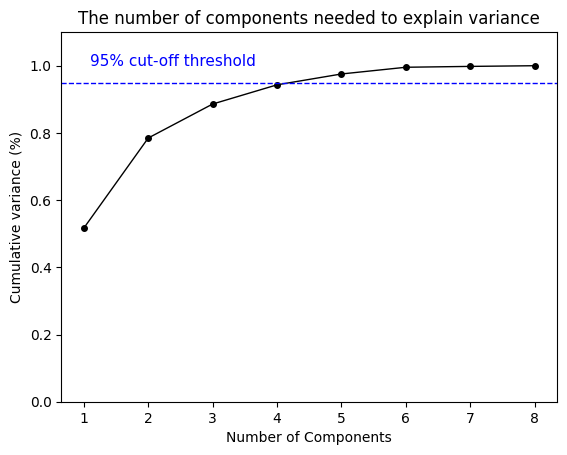

In [50]:
pca = PCA().fit(df_sc)

plt.ylim(0.0,1.1)
plt.plot(np.arange(1, 9), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-', color='black',
         linewidth=1, markersize=4)

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 9)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='blue', linestyle='--', linewidth=1)
plt.text(1.1, 1, '95% cut-off threshold', color = 'blue', fontsize=11)
plt.show()

The amount of variance one needs to capture is not really fixed. <br>
Some say it should be around 95%, others claim 80%.

Choosing only 4 components should be the most correct way as other 3 components contribute very little variance. <br>
But I will go with 2 components (features) that take up 78.4% of the cumulative variance.

In [51]:
pca = PCA(n_components=2).fit(df_sc)
reduced = pca.transform(df_sc)
reduced

array([[-1.27884879, -1.27313333],
       [-1.02055347, -0.20116189],
       [ 0.18828859,  0.43211417],
       ...,
       [ 0.68183395, -2.6861702 ],
       [-1.10391246, -0.11650828],
       [ 3.71252289, -4.90385741]])

In [52]:
display(pca.explained_variance_)
display(pca.explained_variance_ratio_)
display(pca.explained_variance_ratio_.sum())   # Just to double check the values.

array([4.13427769, 2.14472493])

array([0.51675584, 0.26807564])

0.7848314751537151

In [53]:
df_reduced = pd.DataFrame(reduced, columns=['first', 'second'])   # Giving dummy names to these 2 newly formed columns.
df_reduced

first    second
0     -1.278849 -1.273133
1     -1.020553 -0.201162
2      0.188289  0.432114
3     -1.015466 -1.469881
4     -0.822626  2.123651
...         ...       ...
17893 -2.689482  0.136982
17894  0.629805 -1.702292
17895  0.681834 -2.686170
17896 -1.103912 -0.116508
17897  3.712523 -4.903857

[17898 rows x 2 columns]

I will apply the same Hierarchical Agglomerative Clustering (HAC) that I choice at my previous step.

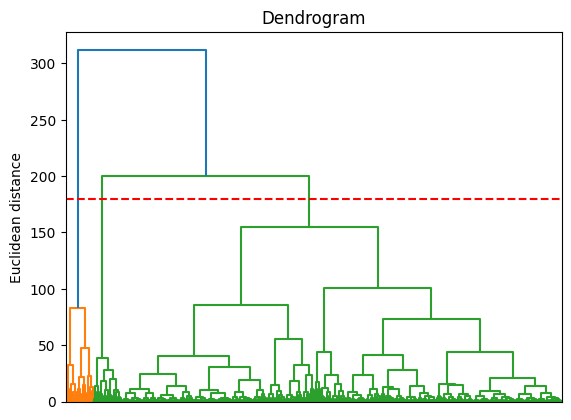

In [54]:
hierarchy.dendrogram(hierarchy.linkage(df_reduced, method='ward'))

plt.title('Dendrogram')
plt.ylabel('Euclidean distance')
plt.xticks([])
plt.axhline(y=180, color='r', linestyle='--')
plt.show()

Again using only two clusters. The red line is plotted just for visualization. <br>
This time I went with metric "l1" and with linkage "average". <br>
But "euclidean" together with "ward" parameters gave almost the same result I must say.

In [55]:
cluster = AgglomerativeClustering(n_clusters=2, metric='l1', linkage='average')
cluster.fit(df_reduced)
h_predicted2 = cluster.labels_
h_predicted2

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [56]:
pd.Series(h_predicted2).value_counts()

0    16825
1     1073
Name: count, dtype: int64

Comparing the clusters of HAC method that was implemented before Principal Component Analysis and after.

In [57]:
df_compare2 = df_compare.copy(deep=True)
df_compare2.head()

mean         sd  excess kurtosis  skewness     mean2        sd2  \
0  140.562500  55.683782        -0.234571 -0.699648  3.199833  19.110426   
1  102.507812  58.882430         0.465318 -0.515088  1.677258  14.860146   
2  103.015625  39.341649         0.323328  1.051164  3.121237  21.744669   
3  136.750000  57.178449        -0.068415 -0.636238  3.642977  20.959280   
4   88.726562  40.672225         0.600866  1.123492  1.178930  11.468720   

   excess kurtosis2   skewness2  k-means  HAC  
0          7.975532   74.242225        0    0  
1         10.576487  127.393580        0    0  
2          7.735822   63.171909        0    0  
3          6.896499   53.593661        0    0  
4         14.269573  252.567306        0    0

In [58]:
df_compare2['HAC_2'] = h_predicted2
df_compare2.rename(columns={'HAC': 'HAC_1'}, inplace=True)
df_compare2.drop(columns=['k-means'], inplace=True)
df_compare2.head()

mean         sd  excess kurtosis  skewness     mean2        sd2  \
0  140.562500  55.683782        -0.234571 -0.699648  3.199833  19.110426   
1  102.507812  58.882430         0.465318 -0.515088  1.677258  14.860146   
2  103.015625  39.341649         0.323328  1.051164  3.121237  21.744669   
3  136.750000  57.178449        -0.068415 -0.636238  3.642977  20.959280   
4   88.726562  40.672225         0.600866  1.123492  1.178930  11.468720   

   excess kurtosis2   skewness2  HAC_1  HAC_2  
0          7.975532   74.242225      0      0  
1         10.576487  127.393580      0      0  
2          7.735822   63.171909      0      0  
3          6.896499   53.593661      0      0  
4         14.269573  252.567306      0      0

HAC_1 represents the first clusters generated before applying PCA. <br>
HAC_2 represents the second clusters generated after applying PCA. <br>

#### Comparing:
An "old" one before PCA: &emsp; &emsp; &emsp; &emsp; HAC_1. <br>
A "new", "modified" one after PCA: &emsp;  HAC_2. 

In [59]:
print(df_compare2['HAC_1'].value_counts())
print(df_compare2['HAC_2'].value_counts())

HAC_1
0    15531
1     2367
Name: count, dtype: int64
HAC_2
0    16825
1     1073
Name: count, dtype: int64


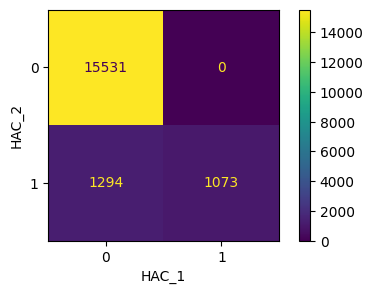

In [60]:
fig, ax = plt.subplots(figsize=(5, 3))
ConfusionMatrixDisplay.from_predictions(h_predicted, h_predicted2, ax=ax) 
plt.xlabel('HAC_1')
plt.ylabel('HAC_2')
plt.show()

Clusters remain quite similar, however 1294 points have swapped places.

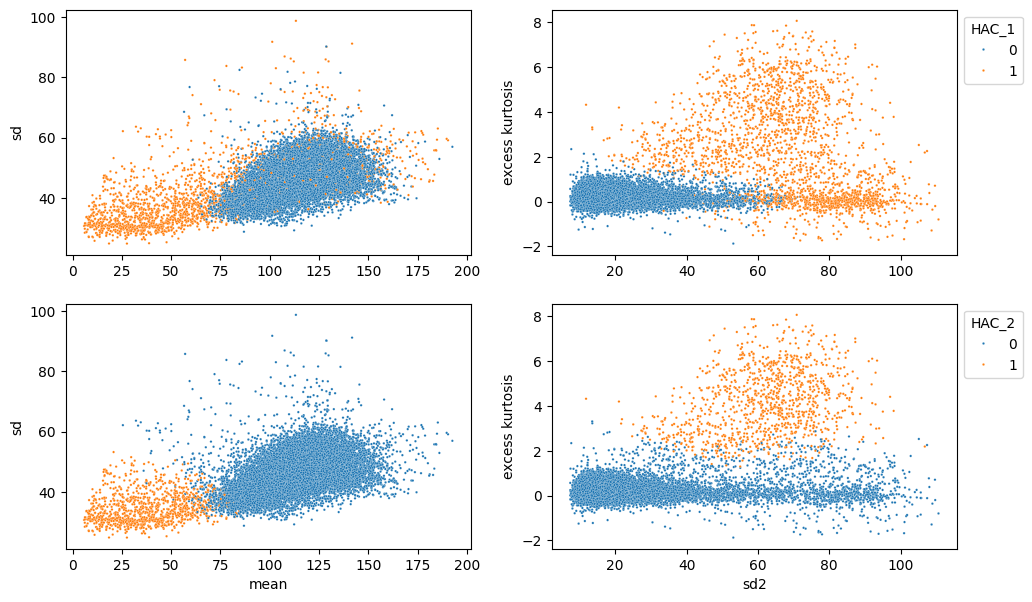

In [61]:
fig, axes = plt.subplots(2,2, figsize=(11.5,7))

ax1 = sns.scatterplot(data=df_compare2, x='mean', y='sd', hue='HAC_1', s=3, ax=axes[0,0], legend=False)
ax2 = sns.scatterplot(data=df_compare2, x='sd2', y='excess kurtosis', hue='HAC_1', s=3, ax=axes[0,1])
ax3 = sns.scatterplot(data=df_compare2, x='mean', y='sd', hue='HAC_2', s=3, ax=axes[1,0], legend=False)
ax4 = sns.scatterplot(data=df_compare2, x='sd2', y='excess kurtosis', hue='HAC_2', s=3, ax=axes[1,1])

sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(ax4, "upper left", bbox_to_anchor=(1, 1))
ax1.set_xlabel(None)
ax2.set_xlabel(None)
plt.show()

Above I visualized 4 columns: "mean" with "sd" and "sd2" with "excess kurtosis" of the original dataset. <br>
The first row represents the first, initial hierarchical clustering method, while the second row shows the same method but after PCA application. <br>

I can see that two cluster are more distinctively formed after PCA dimensionality reduction. <br>
The clusters have become more clear.

In [62]:
display(df_compare2.groupby('HAC_1')[['mean', 'sd']].agg(['mean', 'min', 'max', 'std']).reset_index())
display(df_compare2.groupby('HAC_2')[['mean', 'sd']].agg(['mean', 'min', 'max', 'std']).reset_index())

HAC_1        mean                                          sd             \
               mean       min         max        std       mean        min   
0     0  115.945879  56.53125  192.617188  16.824520  47.053232  28.698714   
1     1   79.152438   5.81250  190.421875  44.097851  43.244515  24.772042   

                         
         max        std  
0  90.250557   5.889110  
1  98.778911  10.676642

HAC_2        mean                                           sd             \
               mean        min         max        std       mean        min   
0     0  115.638028  25.507812  192.617188  18.181795  47.302533  28.698714   
1     1   39.608064   5.812500   86.234375  18.956124  34.742214  24.772042   

                        
         max       std  
0  98.778911  6.223846  
1  53.188147  5.044044

In [63]:
display(df_compare2.groupby('HAC_1')[['skewness', 'excess kurtosis']].agg(['mean', 'min', 'max', 'std']).reset_index())
display(df_compare2.groupby('HAC_2')[['skewness', 'excess kurtosis']].agg(['mean', 'min', 'max', 'std']).reset_index())

HAC_1   skewness                                 excess kurtosis            \
              mean       min        max        std            mean       min   
0     0   0.391697 -1.791886   8.367704   0.918366        0.222222 -1.876011   
1     1  10.815805 -1.781888  68.101622  13.707676        2.155201 -1.738021   

                       
        max       std  
0  2.341728  0.301022  
1  8.069522  2.173861

HAC_2   skewness                                 excess kurtosis            \
              mean       min        max        std            mean       min   
0     0   0.448020 -1.791886  11.110487   1.103119        0.241783 -1.876011   
1     1  22.503746  4.684748  68.101622  12.582256        4.179578  1.297816   

                       
        max       std  
0  3.312638  0.383197  
1  8.069522  1.416683

From this aggregated info I see that the standard deviation reduced for "modified" version of hierarchical method (after PCA) for cluster 1. <br>
And the cluster 0 for hierarchical after PCA it actually increased. <br>
So, the cluster 1 after PCA has become denser, less sparse and cluster 0 has become the opposite - more spread out.

Finally, let's visualize our two methods on the reduced (from PCA) dataframe.

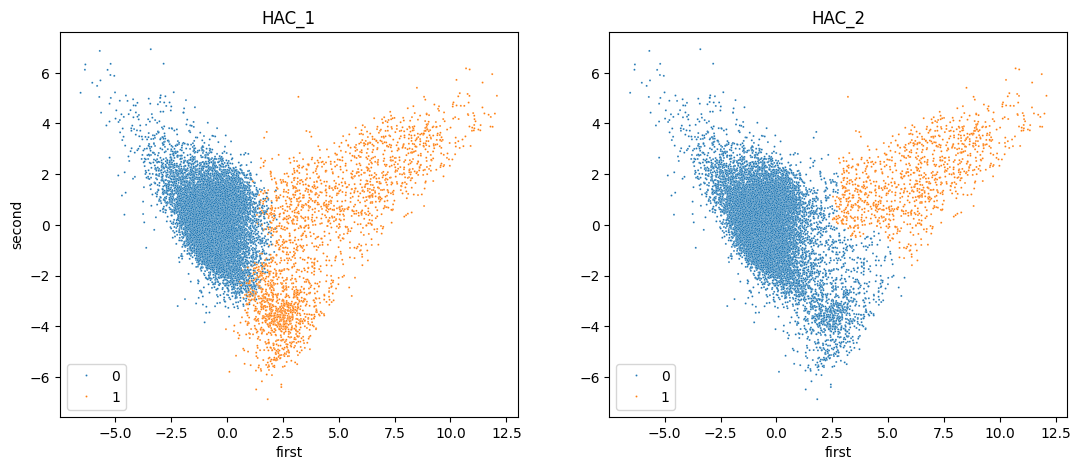

In [64]:
fig, axes = plt.subplots(1,2, figsize=(13,5))
ax1 = sns.scatterplot(x=df_reduced['first'], y=df_reduced['second'], hue=h_predicted, s=2, ax=axes[0])
ax2 = sns.scatterplot(x=df_reduced['first'], y=df_reduced['second'], hue=h_predicted2, s=2, ax=axes[1])
ax1.set(title='HAC_1')
ax2.set(title='HAC_2')
ax2.set_ylabel(None)
plt.show()

It's quite difficult to choose the method but I will go with the second one, namely HAC_2. <br>
I feel like the second graph depicts clusters in a better way. <br>
I will choose the HAC_2 method as my final clustering method. <br>

#### Let's explore specifically HAC_2 method and interpret the final clusters. <br>

Using the reduced dataframe columns at first.

I will add HAC_2 labels to my reduced dataframe.

In [65]:
df_reduced['cluster'] = h_predicted2
df_reduced.head()

first    second  cluster
0 -1.278849 -1.273133        0
1 -1.020553 -0.201162        0
2  0.188289  0.432114        0
3 -1.015466 -1.469881        0
4 -0.822626  2.123651        0

Charts below show density distribution of the final two columns with respect to each cluster.

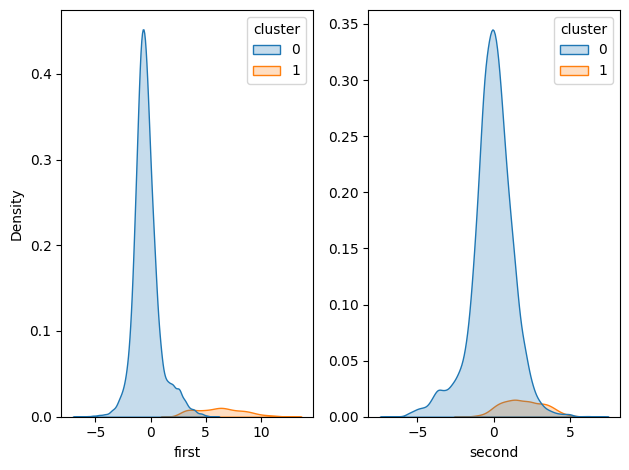

In [66]:
fig, ax = plt.subplots(1,2)
ax1 = sns.kdeplot(data=df_reduced, x='first', hue='cluster', fill=True, ax=ax[0], levels=5)
ax2 = sns.kdeplot(data=df_reduced, x='second', hue='cluster', fill=True, ax=ax[1])
ax2.set_ylabel(None)
plt.tight_layout()

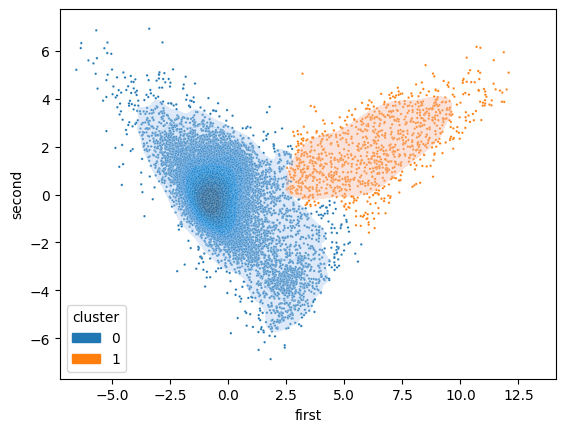

In [67]:
sns.scatterplot(data=df_reduced, x='first', y='second', hue='cluster', s=3)
sns.kdeplot(data=df_reduced, x='first', y='second', hue='cluster', fill=True, alpha=0.4)
plt.show()

We can clearly see, that the majority of data point lie in cluster 0. <br>

We can also observe, that there are 3 distinct groups (clusters) on the graph. <br>
The first one (in blue colour) is on the left. <br>
The second one (in blue colour) is in the middle of the bottom. <br>
The last one (in orange colour) is on the right of the graph.

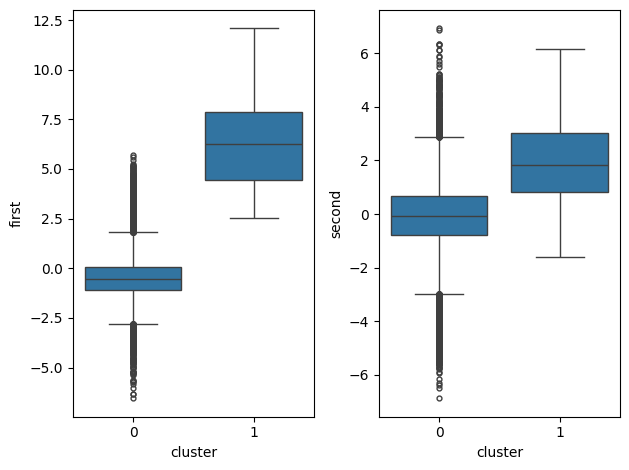

In [68]:
fig, ax = plt.subplots(1,2)
sns.boxplot(data=df_reduced, x='cluster', y='first', fliersize=3.5, ax=ax[0])
sns.boxplot(data=df_reduced, x='cluster', y='second', fliersize=3.5, ax=ax[1])
plt.tight_layout()
plt.show()

Cluster 0 has a lot of "outliers", while cluster 1 has no outliers. <br>

#### Now, let's visualize our final clusters on the original columns.

In [69]:
df_final = df.copy(deep=True)   # Just creating a copy of the original dataset to avoid possible errors.
df_final['cluster'] = h_predicted2   # Adding our predicted clusters.
df_final.head()

mean         sd  excess kurtosis  skewness     mean2        sd2  \
0  140.562500  55.683782        -0.234571 -0.699648  3.199833  19.110426   
1  102.507812  58.882430         0.465318 -0.515088  1.677258  14.860146   
2  103.015625  39.341649         0.323328  1.051164  3.121237  21.744669   
3  136.750000  57.178449        -0.068415 -0.636238  3.642977  20.959280   
4   88.726562  40.672225         0.600866  1.123492  1.178930  11.468720   

   excess kurtosis2   skewness2  cluster  
0          7.975532   74.242225        0  
1         10.576487  127.393580        0  
2          7.735822   63.171909        0  
3          6.896499   53.593661        0  
4         14.269573  252.567306        0

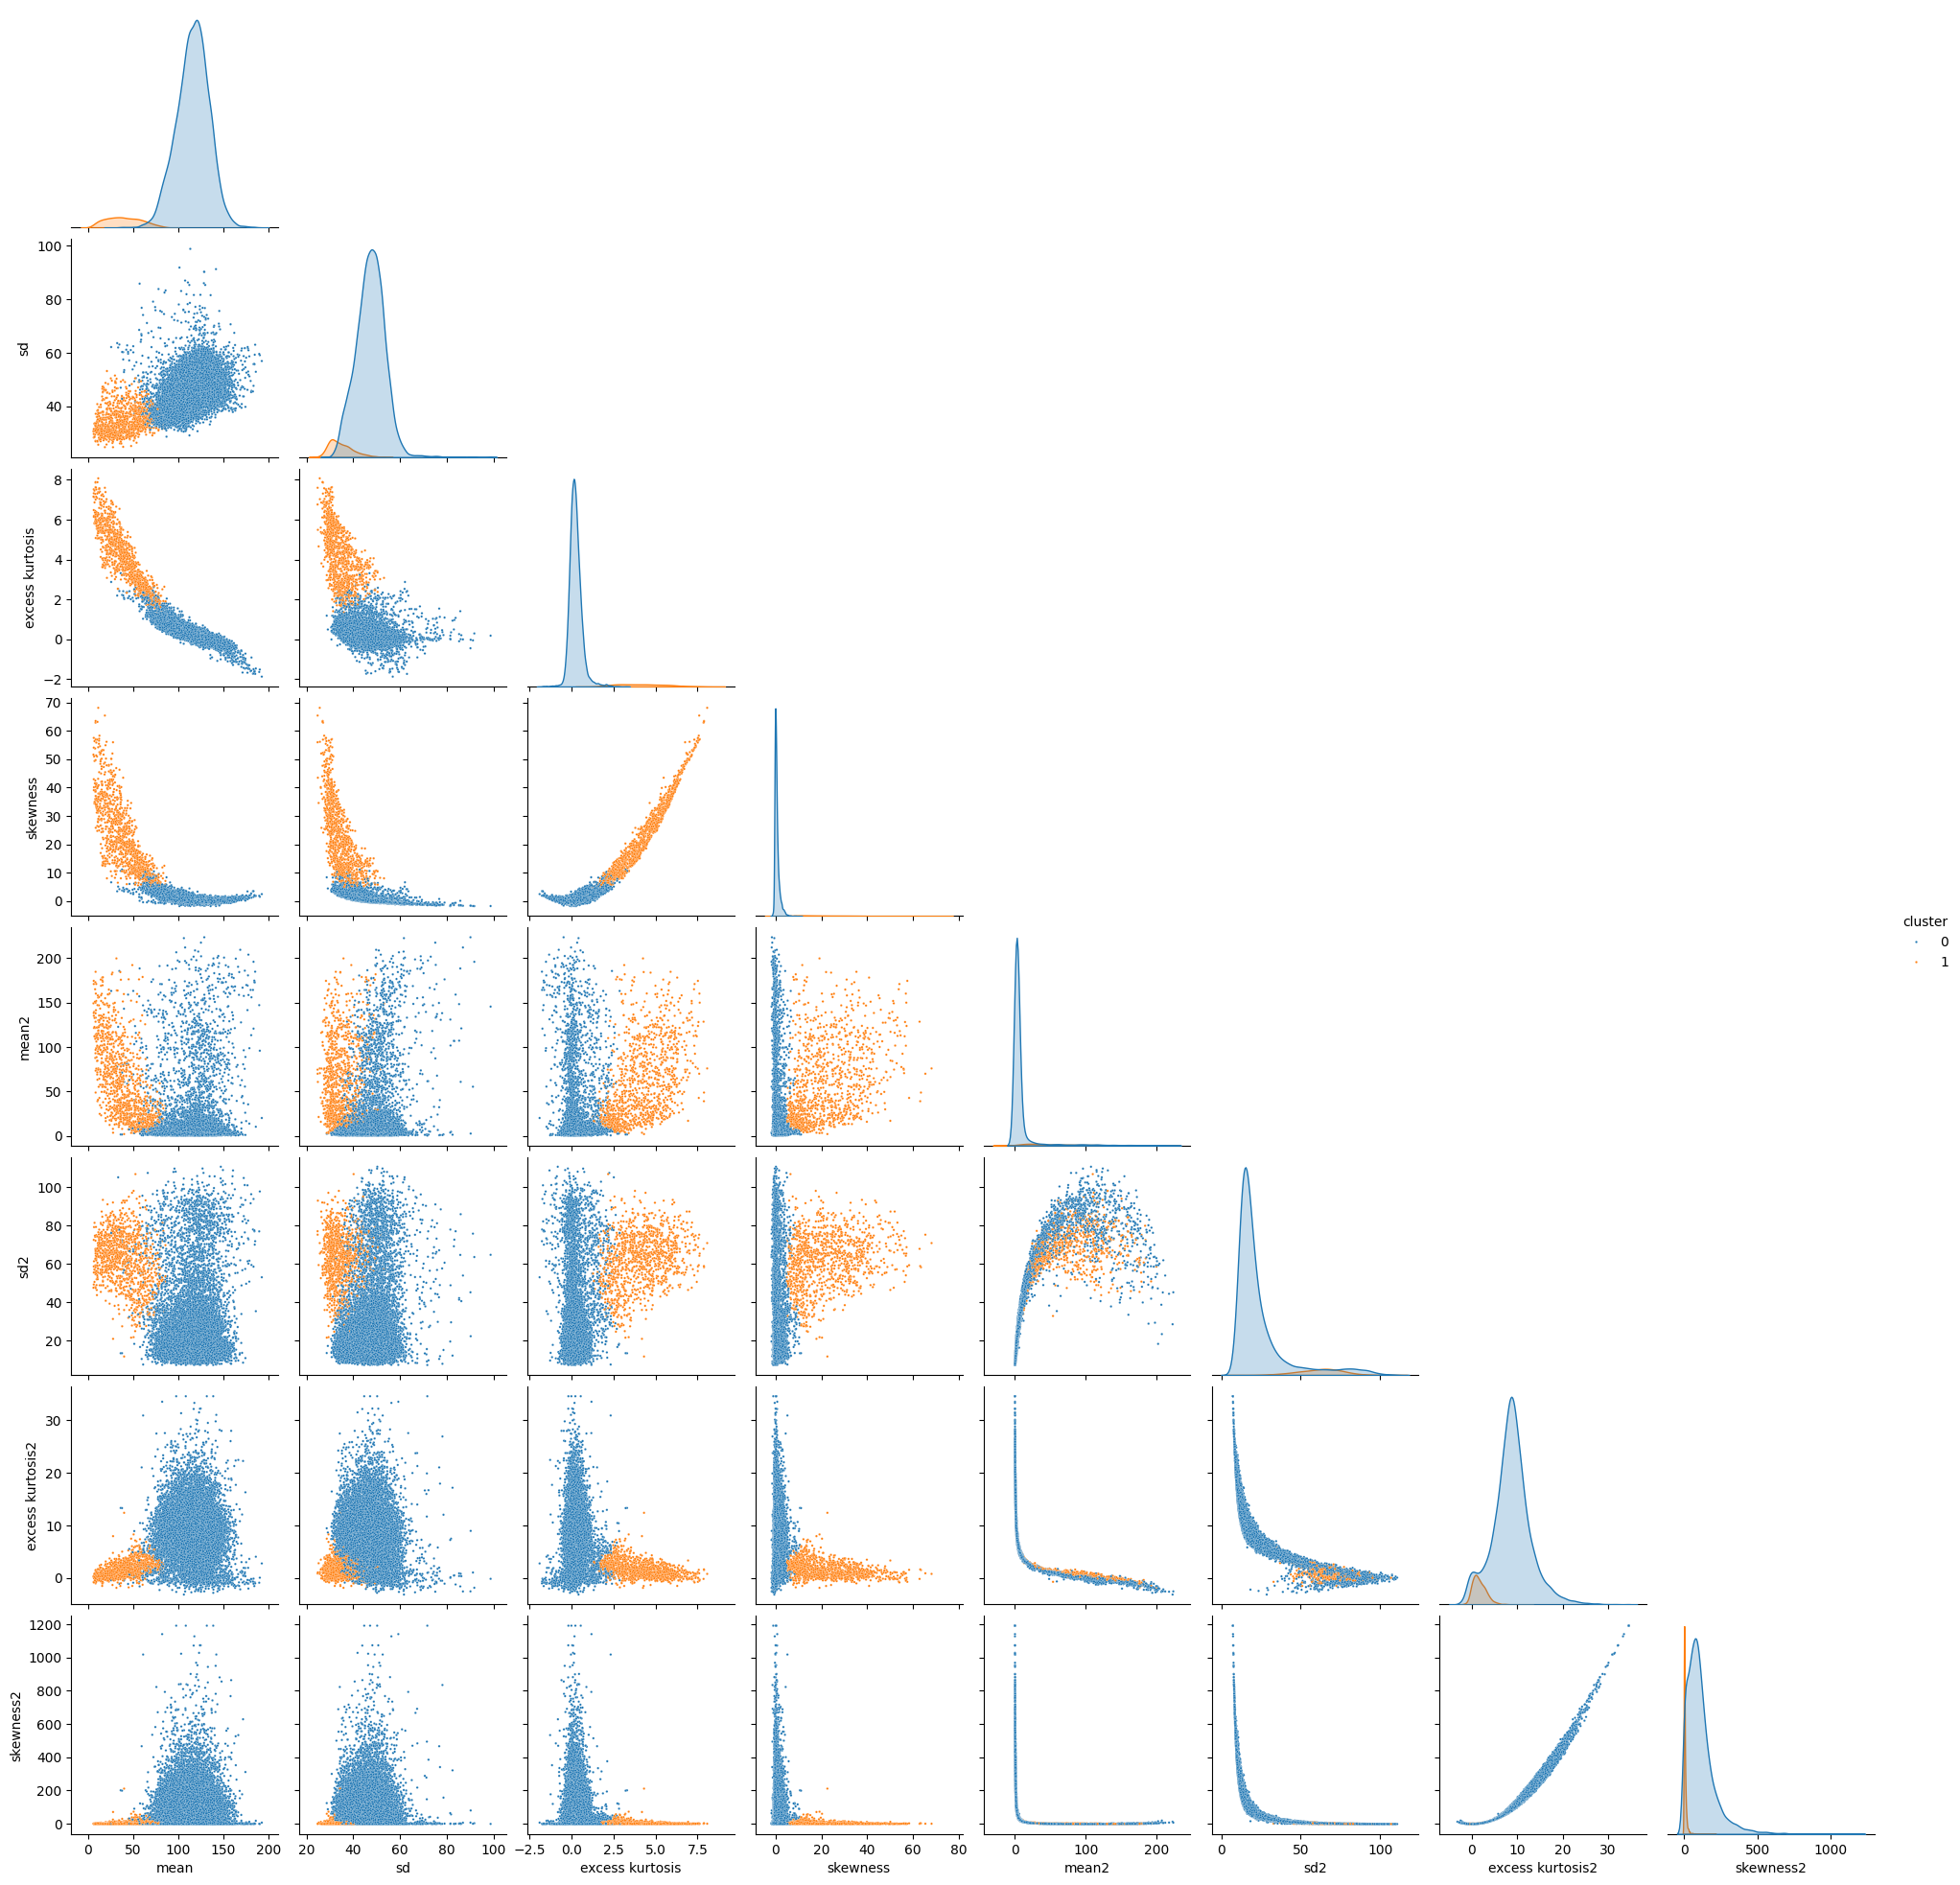

In [70]:
sns.pairplot(data=df_final, hue='cluster', corner=True, plot_kws={"s": 3})
plt.show()

Some graphs show more or less distinct clusters, while others describe the groups quite poorly.

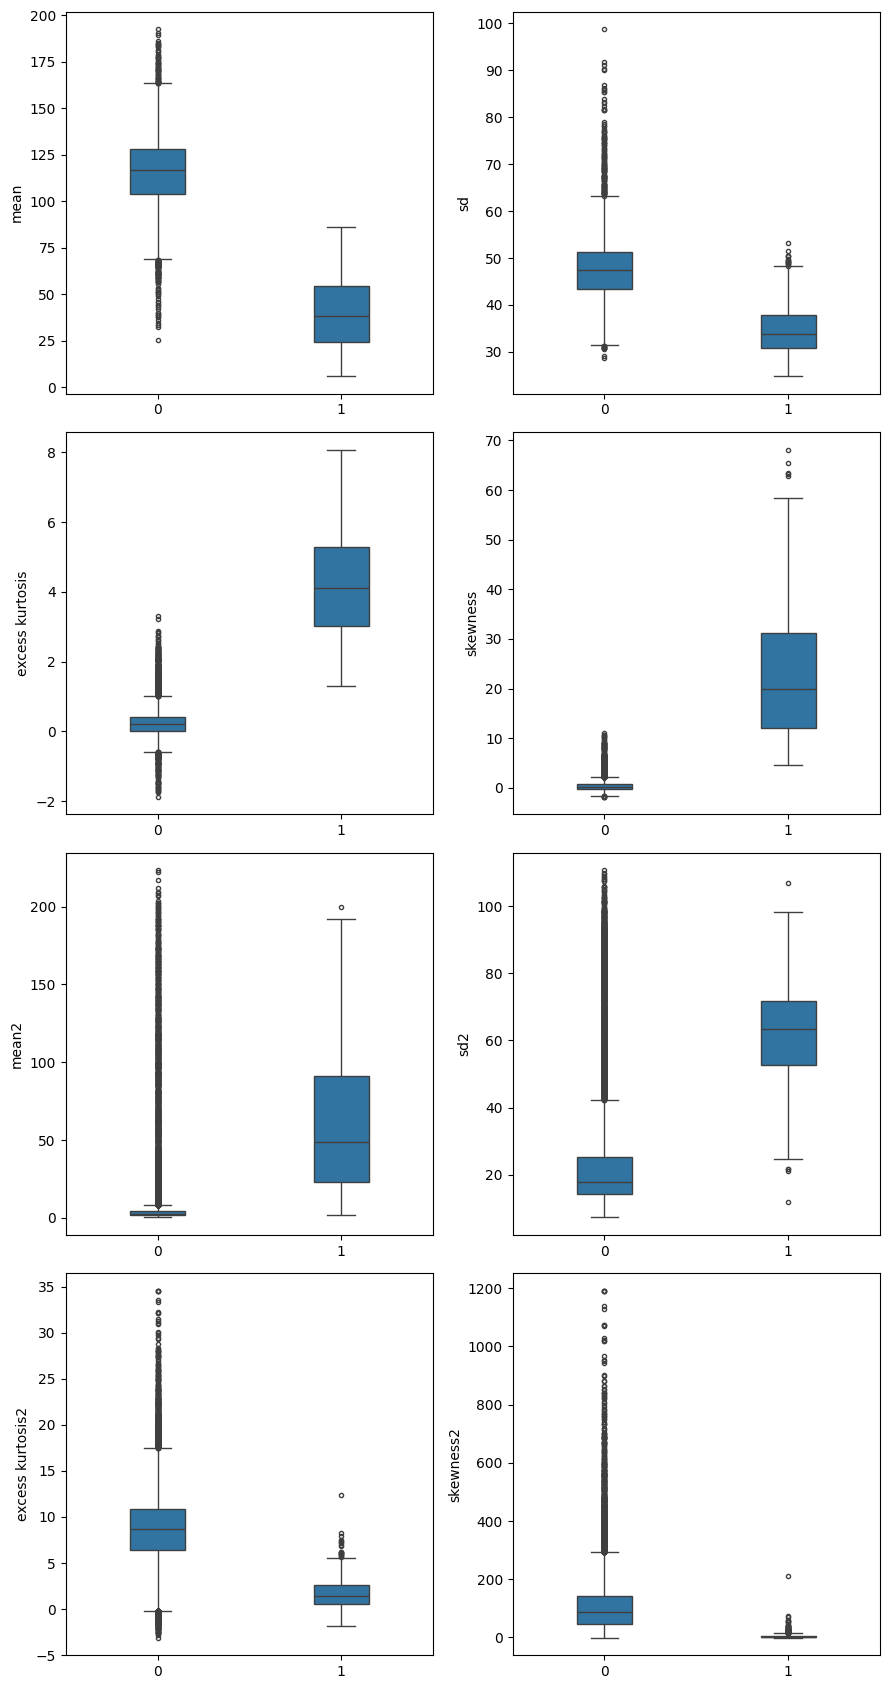

In [71]:
figure, axes = plt.subplots(4, 2, figsize=(9,17))
for i, ax in enumerate(axes.flatten()):
    column = df_final.columns[i]
    sns.boxplot(data=df_final, x='cluster', y=column, ax=ax, fliersize=3, width=0.3)
    ax.set(xlabel='')

plt.tight_layout()

And again cluster 0 has a lot of outliers, while cluster 1 has almost no outliers. <br>
So, cluster 1 is highly spread out and cluster 1 is the opposite - compact.

So, records of cluster 0 are to be interpreted as unimportant "noise". <br>
And records of cluster 1 are to be understood as potential pulsar candidates and they should be explored by scientists first.

I had my "answers" (target variable) that I hid on purpose in the beginning of this project. <br>
So, I will compare my result with the actual values. <br>
I will use my reduced (after PCA) dataframe.

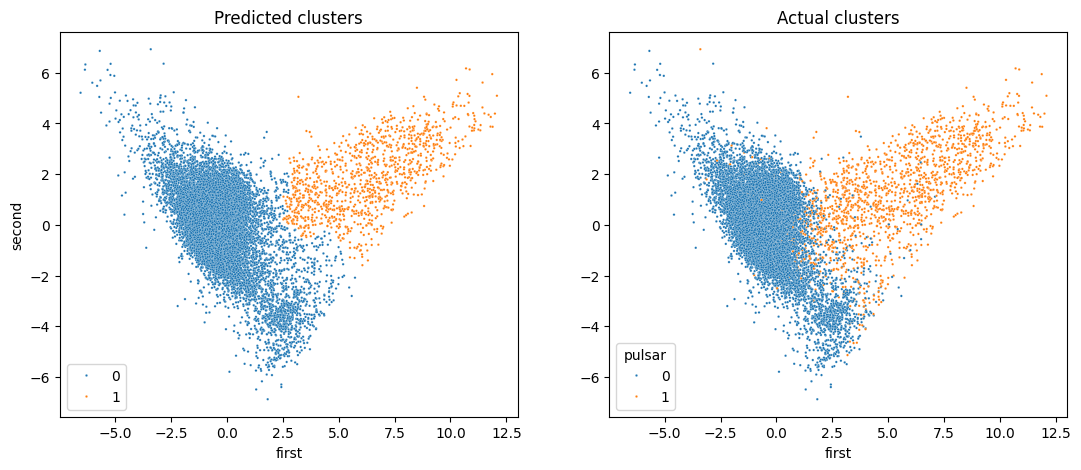

In [72]:
fig, axes = plt.subplots(1,2, figsize=(13,5))
ax1 = sns.scatterplot(x=df_reduced['first'], y=df_reduced['second'], hue=h_predicted2, s=3, ax=axes[0])
ax2 = sns.scatterplot(x=df_reduced['first'], y=df_reduced['second'], hue=df_or['pulsar'], s=3, ax=axes[1])
ax1.set(title='Predicted clusters')
ax2.set(title='Actual clusters')
ax2.set_ylabel(None)
plt.show()

In [73]:
df_or[df_or['pulsar']==pd.Series(h_predicted2)]['pulsar'].value_counts()
# A number of matching clustering groups from predicted to the real ones.

pulsar
0    16239
1     1053
Name: count, dtype: int64

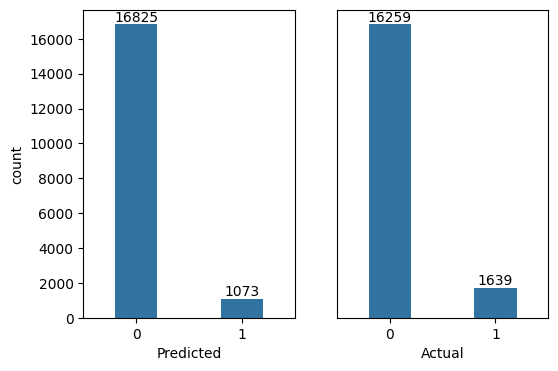

In [74]:
fig, axes = plt.subplots(1,2, figsize=(6,4))
ax1 = sns.countplot(df_final, x='cluster', ax=axes[0], width=0.4)
ax2 = sns.countplot(df_or, x='pulsar', ax=axes[1], width=0.4)

ax1.bar_label(ax1.containers[0])
ax2.bar_label(ax2.containers[0])
ax1.set(xlabel='Predicted')
ax2.set(xlabel='Actual')
ax2.set(ylabel=None)
ax2.set(yticks=[])
plt.show()

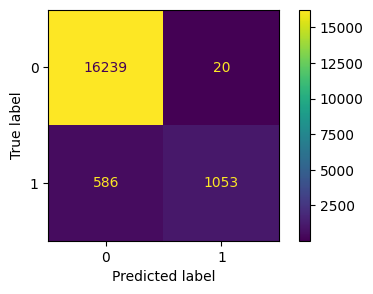

In [75]:
fig, ax = plt.subplots(figsize=(5, 3))
ConfusionMatrixDisplay.from_predictions(df_or['pulsar'], h_predicted2, ax=ax)   # true values, predicted values.
plt.show()

Looking from predicted clusters: <br>
20 records out of 1073 were detected wrong as pulsars. It gives 98.1 % accuracy. <br>
586 records out of 16 825 were wrongfully identified as "noise". It gives 96.5 % accuracy. <br>

Looking from real (actual) clusters: <br>
1053 pulsars out of 1639 were identified correctly , which is 64.2 % accuracy. <br>
16 239 "noise" records out of 16 259 were classified correctly, which is 99.8 % accuracy.

#### Conclusion <br>

1. At first, the data understanding, preprocessing and visualization was performed to get initial insights. <br>
2. Then 3 clustering methods were used: k-Means, DBSCAN and HAC. Each produced 2 cluster groups. <br>
3. Out of these 3 algorithms only k-Means and HAC were compared. The resulting clusters were similar, but the HAC was chosen in the end. <br>
4. After that, Principal Component Analysis was implemented to reduce data dimensionality and remove irrelevant features. <br>
5. A new HAC_2 was used again after PCA and then compared with the old one implemented before PCA. <br>
6. The updated HAC_2 method after PCA (dimensionality reduction) was chosen as the final method with its formed clusters. <br>
7. The final two cluser groups (group 0 and group 1) were interpreted, analyzed and visualized.

The groups are quite different from each other in terms of data distribution. Group 0 has 16 825 entries, group 1 has only 1073 records. <br>
It tells us that the data is imbalanced. There are a lot of records from group 0 and very little records from group 1. <br>
This should make sense, because the amount of irrelevant signals coming from space must be much higher than "good", valuable signals <br> from specific stars that we are interested in. <br>

Now, that the singlas are clustered, scientists can work directly with potential pulsar candidates, which belong to <br> cluster 1 without spending their time analyzing records from cluster 0. <br>
I can say that my initial goal was achieved. I managed to filter out irrelevant records from the desired ones. <br>
The next step could be using a classification algorithm to identify new coming signals as pulsars or noise. <br>

As for limitations I can say that since I only used and compared two clustering methods I missed a chance to compare other methods <br> like Clarans and EM (Expectation Maximization). I also kind of knew that there should be only two clusters that's why I chose in each of <br> my method 2 clusters. My dataset was relatively small, so I didn't care if my clustering algorithm was computationally expensive as it didn't take long to run. <br>
I didn't compare my hyperparameters well enough when choosing my clustering method. I shoul have used my dataset features to see how similar <br> or different my clusters were. This is something that can be done in the future work.

As I was biased to choose two clusters in my work I would love to see how 3 clusters would look like. <br>
I will quickly visualize 3 clustering groups from HAC method on the reduced dataframe.

In [76]:
cluster = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
cluster.fit(df_reduced[['first', 'second']])
h_predicted3 = cluster.labels_
pd.Series(h_predicted3).value_counts()

0    15880
1     1031
2      987
Name: count, dtype: int64

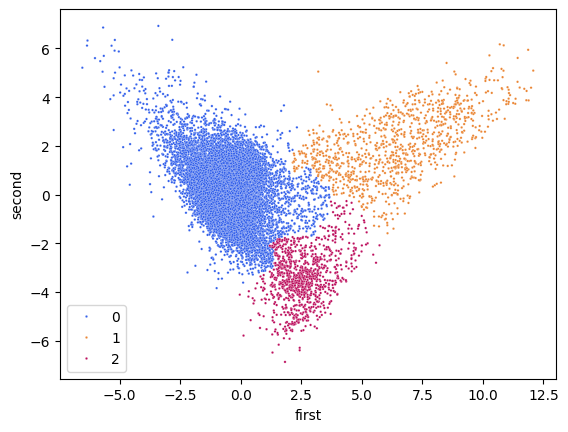

In [77]:
sns.scatterplot(x=df_reduced['first'], y=df_reduced['second'], hue=h_predicted3, palette=['#3461eb' ,'#eb8634', '#bd0f5d'], s=3)
plt.show()

#### For future work: <br>
1. This looks very nice. And it should be analyzed together with k-Means using also 3 clusters. <br>
2. Other methods with different parameters and a different number of clusters can also be used and compared in the future work. <br>
3. Silhouette Scores can be visualized to better determine the number of groups for the K-means method. <br>
4. A MinMaxScaler can be used instead of a StandardScaler. <br>
5. A different number of features (only 4) can be chosen and compared during PCA.
6. A density-based algorithm might not work well, because many "outliers" turn out to be our actual pulsars. If this type of algorithm <br>
treats them as such then we will lose valuable points in our clustering groups.